In [1]:
import pandas as pd
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cf
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import numpy as np
import numpy.matlib as matlib
import regionmask
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [2]:
## Load obs data for masks of beta values
fname = '/glade/work/tanderson/GPCC/gpcc_05_v2020.nc'

def is_GS(month):
    return (month >= 5) & (month <= 10)

#Load GPCC obs
dset_obs = xr.open_mfdataset(fname)
dset_obs = dset_obs.sel(lat=slice(18,11), lon=slice(-93,-83), time=slice('1920-01-01','2019-12-01')) # slice data to lat and lons of interest

dset_obs.attrs['units'] = 'mm/month'

dset_obs_year = dset_obs['time.year']
dset_obs_month = dset_obs['time.month']

# Make a regional mask
land = regionmask.defined_regions.natural_earth_v5_0_0.land_10.mask(dset_obs)

# Precip Masked
obsLand = dset_obs.where(land==0).load()
#obsLand.precip[1].plot()

 # Get annual precip total 
annObs = obsLand.groupby('time.year').sum('time', skipna=False, keep_attrs=True) 
    
# Get annual GS total
GSObs = obsLand.sel(time=is_GS(obsLand['time.month']))
GSObs = GSObs.groupby('time.year').sum('time', skipna=False, keep_attrs=True) 

# Calculate % of annual rainfall in GS
GSpercObs = np.divide(GSObs,annObs)*100

# Get average annual % of rainfall
avgGSpercObs = GSpercObs.mean('year', keep_attrs=True)
    
# Get mean growing season precip
meanGSObs = GSObs.mean('year', keep_attrs=True)
   
# Get annual anomalies of % of normal growing season rainfall
GSanomPObs = np.divide(GSObs,meanGSObs)*100-100
 
# Mask where annual growing season rainfall <75% of annual
GSanomPObs = GSanomPObs.where(avgGSpercObs>75)
    

In [4]:
# Load beta files
beta_fname = '/glade/work/tanderson/obsLE/parameters_v-noF_CLLJV2_v02_CentAm_Pr_05deg_blockNew/obs/pr/beta.nc'

# Open beta file
betas_all = xr.open_mfdataset(beta_fname)

# Extract betas for ENSO and CLLJ
beta_ENSO = betas_all.beta_ENSO
beta_CLLJ = betas_all.beta_CLLJ

# Mask based on 75% threshold
beta_ENSO = beta_ENSO.where(avgGSpercObs>75)
beta_CLLJ = beta_CLLJ.where(avgGSpercObs>75)


<xarray.Dataset>
Dimensions:  (month: 12, lat: 14, lon: 20)
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * lat      (lat) float64 17.75 17.25 16.75 16.25 ... 12.75 12.25 11.75 11.25
  * lon      (lon) float64 -92.75 -92.25 -91.75 -91.25 ... -84.25 -83.75 -83.25
Data variables:
    precip   (month, lat, lon) float64 dask.array<chunksize=(12, 14, 20), meta=np.ndarray>
Attributes: (12/22)
    CDI:                       Climate Data Interface version 2.0.3 (https://...
    Conventions:               CF-1.4
    institution:               Deutscher Wetterdienst
    history:                   Wed Sep 14 11:01:55 2022: cdo -r -f nc4 -z zip...
    title:                     GPCC Full Data Monthly Product Version 2022, p...
    summary:                   The Full Data Monthly Product is of much highe...
    ...                        ...
    geospatial_lat_max:        90.
    geospatial_lon_min:        -180.
    geospatial_lon_max:        180.
    doi:                    

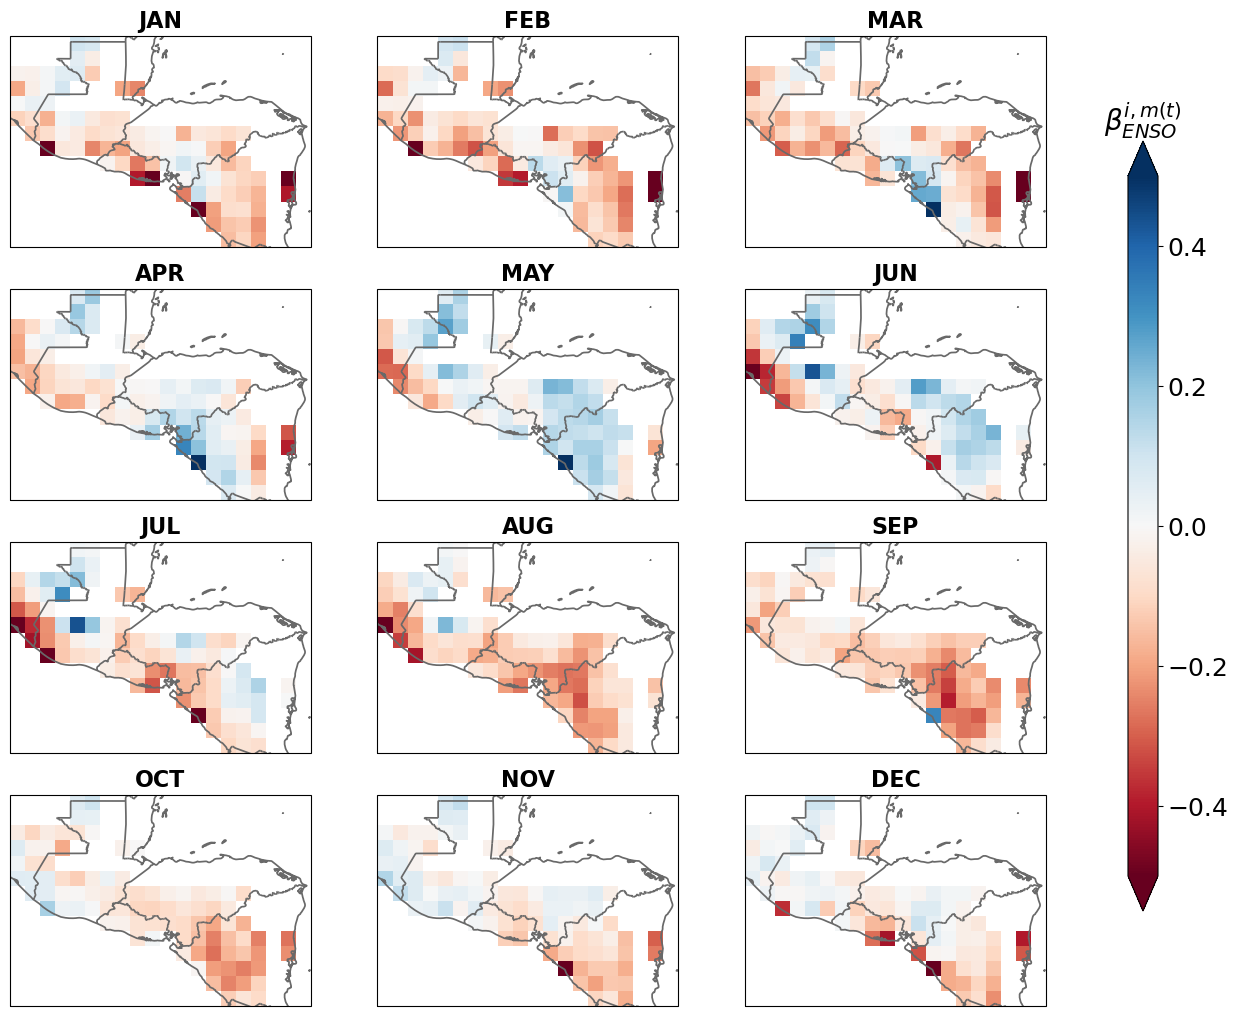

In [9]:
# Plot monthly betas for ENSO

plot_titles = ["JAN", "FEB", "MAR", "APR", "MAY", "JUN", "JUL", "AUG", "SEP", "OCT", "NOV", "DEC"]

fig, axs = plt.subplots(nrows=4, ncols=3,figsize=(15,10),subplot_kw={'projection': ccrs.PlateCarree()})
fig.tight_layout()
axs = axs.flatten()
figsize=(25, 20)

vmin = -0.5
vmax = 0.5
norm = mpl.colors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

for i in range(1, 13):
    beta_mon = beta_ENSO.sel(month=i)
    plt1=beta_mon.precip.plot(ax=axs[i-1], cmap='RdBu',transform=ccrs.PlateCarree(),add_colorbar = False,
                             vmin=vmin, vmax=vmax, norm=norm)
    axs[i-1].set_extent([-93.01, -82.99, 10.99, 18.01])
    axs[i-1].add_feature(cf.COASTLINE,edgecolor='dimgray',linewidth=1.25)
    axs[i-1].add_feature(cf.BORDERS,edgecolor='dimgray',linewidth=1.25)
    axs[i-1].set_title(plot_titles[i-1], fontweight = 'bold', fontsize=16)
 
plt.subplots_adjust(hspace=0.2, wspace=-0.5)

# Add a colorbar axis on the right of the figure
cbar_ax = fig.add_axes([0.9, 0.11, 0.02, 0.77])

# Draw the colorbar
cbar=fig.colorbar(plt1, cax=cbar_ax,orientation='vertical', extend='both')
cbar.ax.set_title(label=r'$\beta_{ENSO}^{i,m(t)}$', weight='bold',fontsize=20)
cbar.ax.tick_params(labelsize=18)
plt.show()
fig.savefig('/glade/work/tanderson/DC_Drought/Figures/ENSO_Betas__v-noF_CLLJV2_v02_CentAm_Pr_05deg_blockNew_.eps', format='eps', bbox_inches='tight')

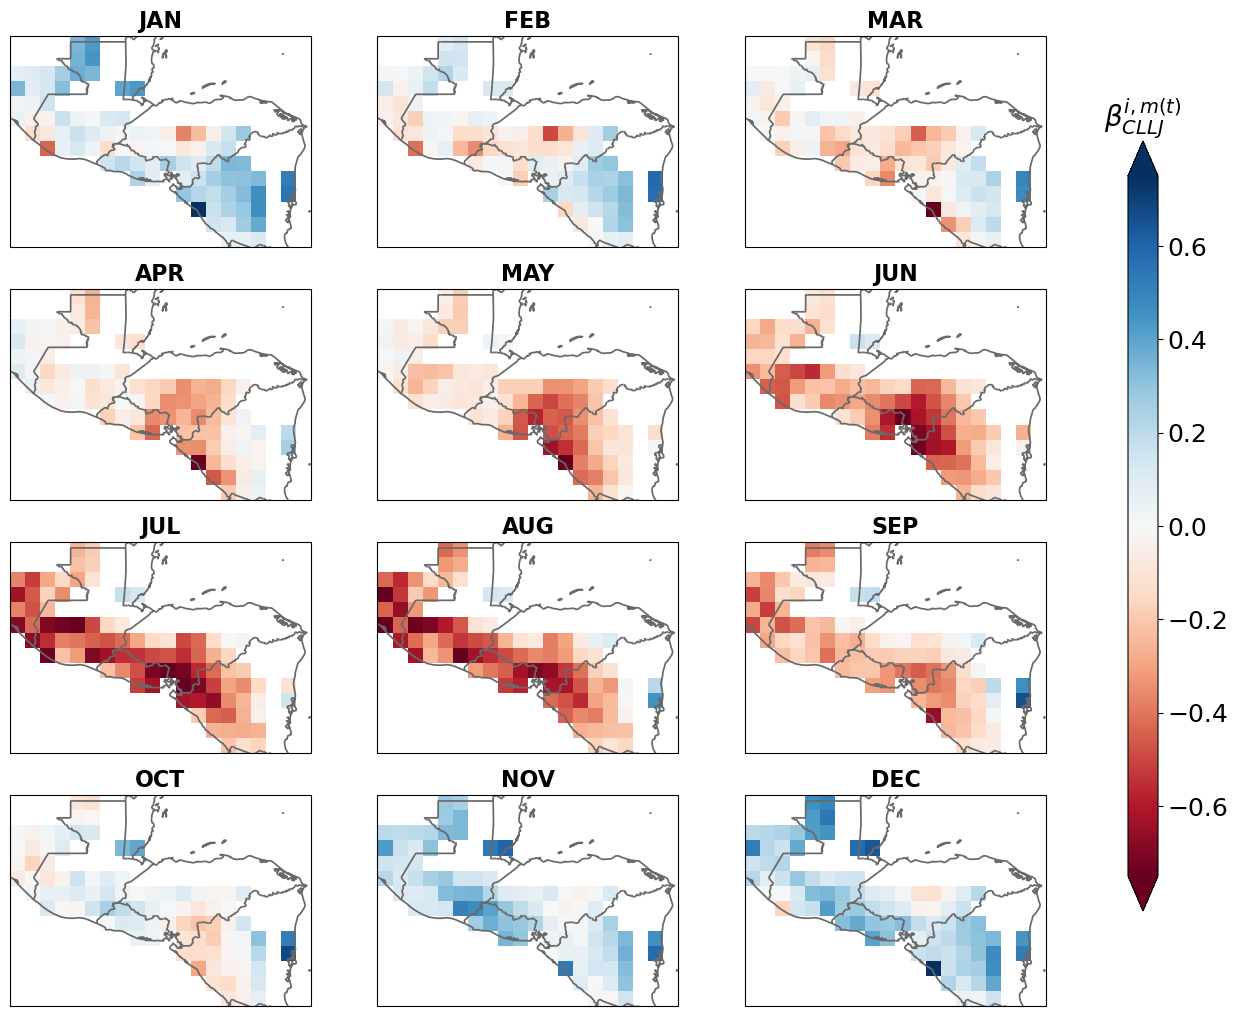

In [10]:
# Plot monthly betas for CLLJ 

plot_titles = ["JAN", "FEB", "MAR", "APR", "MAY", "JUN", "JUL", "AUG", "SEP", "OCT", "NOV", "DEC"]

fig, axs = plt.subplots(nrows=4, ncols=3,figsize=(15,10),subplot_kw={'projection': ccrs.PlateCarree()})
fig.tight_layout()
axs = axs.flatten()
figsize=(25, 20)

vmin = -0.75
vmax = 0.75
norm = mpl.colors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

for i in range(1, 13):
    beta_mon = beta_CLLJ.sel(month=i)
    plt1=beta_mon.precip.plot(ax=axs[i-1], cmap='RdBu',transform=ccrs.PlateCarree(),add_colorbar = False,
                             vmin=vmin, vmax=vmax, norm=norm)
    axs[i-1].set_extent([-93.01, -82.99, 10.99, 18.01])
    axs[i-1].add_feature(cf.COASTLINE,edgecolor='dimgray',linewidth=1.25)
    axs[i-1].add_feature(cf.BORDERS,edgecolor='dimgray',linewidth=1.25)
    axs[i-1].set_title(plot_titles[i-1], fontweight = 'bold', fontsize=16)
 
plt.subplots_adjust(hspace=0.2, wspace=-0.5)

# Add a colorbar axis on the right of the figure
cbar_ax = fig.add_axes([0.9, 0.11, 0.02, 0.77])

# Draw the colorbar
cbar=fig.colorbar(plt1, cax=cbar_ax,orientation='vertical',extend='both')
cbar.ax.set_title(label=r'$\beta_{CLLJ}^{i,m(t)}$', weight='bold',fontsize=20)
cbar.ax.tick_params(labelsize=18)
plt.show()
fig.savefig('/glade/work/tanderson/DC_Drought/Figures/CLLJ_Betas__v-noF_CLLJV2_v02_CentAm_Pr_05deg_blockNew.eps', format='eps', bbox_inches='tight')